<a href="https://colab.research.google.com/github/khojwar/Master_Thesis/blob/main/006_(_Improve3_first_success)_pos_tagging_using_word2Vec_and_GRU_LSTM_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task success Till now are :
Step 1:
1. retrieve tags from directrie's files and store in "tags" list
2. plots bar diagram for tags
  *   One axis represents tags
  *   Other axis represents counts

Step 2: Extract the words and keys from directries xml files

Step 3: Preprocessing and Dataset Preparation

Step 4: split dataset into train, val and test (70:15:15) && Configure the dataset for performance

Step 5: Load pre-trained word embeddings (using Word2Vec)

Step 6: build an LSTM model using Keras

Step 7: Compile and Train the model with train and validation dataset

Step 8: Evaluate the model with test dataset

Step 9: Create a plot of accuracy and loss over time

Step 10: Save the trained model

Step 11: Load the trained model

Step 12: POS Tagging with the LSTM Model


# Problems seen after train the model
1. only deal with seen data. Gives error when dealing with unseen input sequence of words
2. user input दिदा "बाट", "को", "का", "लाई" etc शब्द लाई छुटाइ दिन पर्छ ।
3. can't deal with confilct words

# Step 1:

In [3]:
import os
import xml.etree.ElementTree as ET    #It allows to create, modify, and extract information from XML documents using a simple and intuitive API.
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import tensorflow as tf

In [4]:
# authenticate and mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# Chage directory to project folder
%cd /content/drive/MyDrive/Nepali POS Tagging/
%ls

/content/drive/MyDrive/Nepali POS Tagging
 002_Nepali_pos_tagging_SVM.ipynb
'003_(first_success)_pos_tagging_using_word2Vec_and_LSTM.ipynb'
'005_( Improve2_first_success)_pos_tagging_using_word2Vec_and_LSTM.ipynb.ipynb'
 assets/
'C:\Windows\System32\cmd.exe\output.txt'
 fingerprint.pb
 keras_metadata.pb
 nnc_updated_ah/
 saved_model.pb
 trained_model/
 variables/


# Access the book directory's xml files and create tagsets list

In [6]:
# Set the path to the directory containing XML files
path = 'nnc_updated_ah/gc/books/'
filelist = os.listdir(path)
filelist

['book-academic-rupantaran-2062.xml', 'book-academic-jana-siksha-2058.xml']

In [7]:
tagsets = []

for file in filelist:
    filepath = os.path.join(path, file)
    # print(filepath)

    tree = ET.parse(filepath)   # Parse an XML file and create an ElementTree object
    root = tree.getroot()   # Get the root element of the XML document
    # print(root)

    # Find all "w" elements with a "ctag" attribute
    word_elements = root.findall(".//w[@ctag]")

    # Extract POS tags
    tagset = [word.attrib["ctag"] for word in word_elements]
    tagsets.extend(tagset)



# plot the code

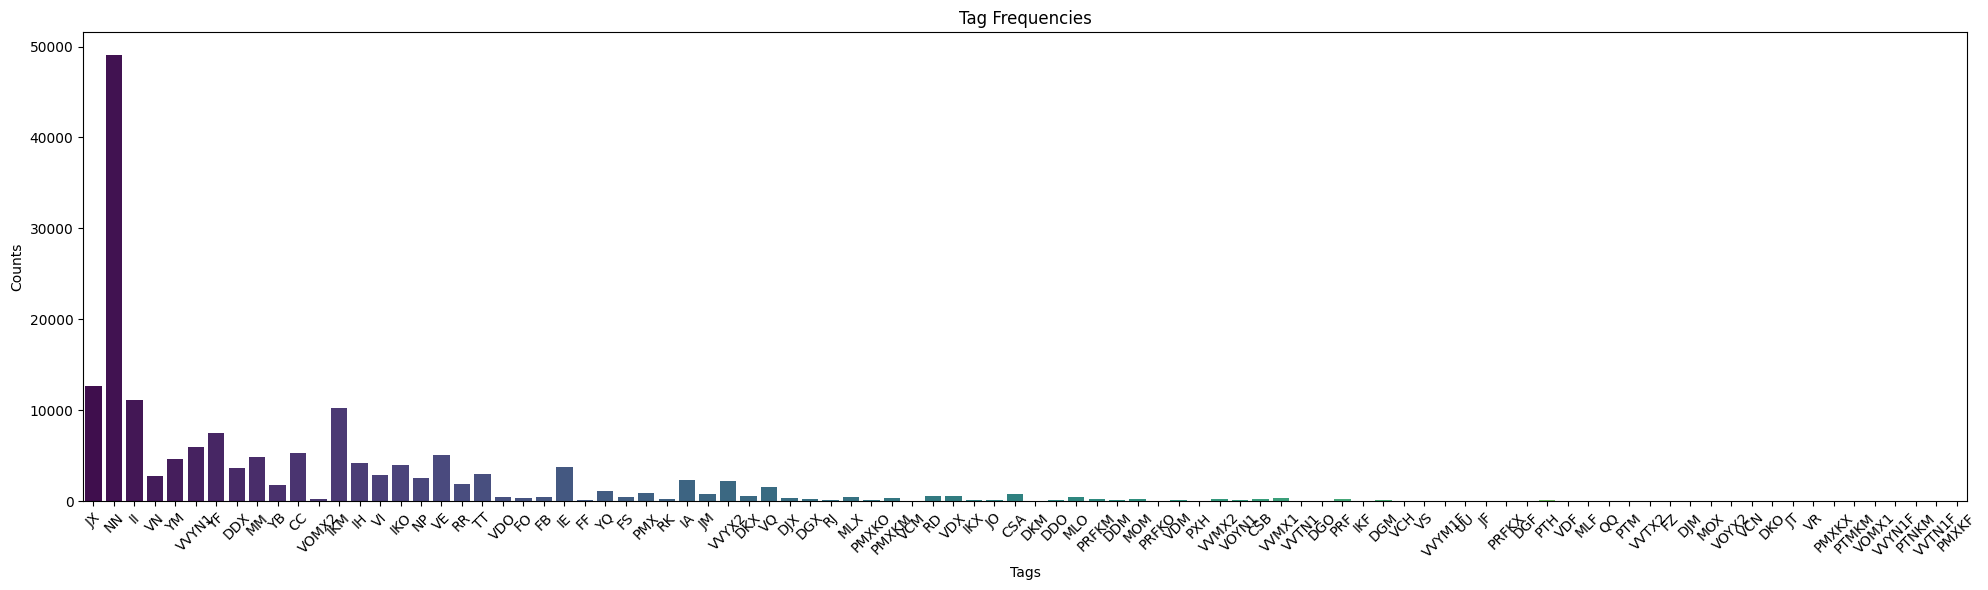

In [8]:
# Count the occurrences of each tag
tag_counts = Counter(tagsets)

# Convert the tag_counts to a DataFrame for Seaborn plotting
tag_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count']).reset_index()
tag_df.rename(columns={'index': 'Tag'}, inplace=True)

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 6))
sns.barplot(x='Tag', y='Count', data=tag_df, palette='viridis')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Tag Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Step 2: Extract the words and keys from directries xml files

In [9]:
all_custom_dataset = []

for file in filelist:
    filepath = os.path.join(path, file)
    # print(filepath)

    tree = ET.parse(filepath)   # Parse an XML file and create an ElementTree object
    # Get the root element of the XML document
    root = tree.getroot()
    # print(root)

    # Find all "w" elements with a "ctag" attribute
    word_elements = root.findall(".//w[@ctag]")

    # Extract words and corresponding POS tags
    custom_dataset = [(word.text, word.attrib["ctag"]) for word in word_elements]
    # custom_dataset = [file]
    all_custom_dataset.extend(custom_dataset)

    # Print the formatted custom dataset
    # print("custom_dataset =", custom_dataset)

# print("hello")
# print(all_custom_dataset)
# print(custom_dataset[:10])

In [10]:
print(len(all_custom_dataset))
print(all_custom_dataset[:10])

164263
[('रूपान्तरणः', 'JX'), ('समाज', 'NN'), ('अध्ययन', 'NN'), ('नेपाली', 'JX'), ('भाषा', 'NN'), ('मा', 'II'), ('प्रकाशित', 'JX'), ('हुने', 'VN'), ('अर्ध', 'JX'), ('–', 'YM')]


#Step 3: Preprocessing and Dataset Preparation

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
words, pos_tags = zip(*all_custom_dataset)

# Tokenize sentences
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence, _ in all_custom_dataset]

# Create a vocabulary
vocab = set(word for sentence in tokenized_sentences for word in sentence)
vocab_size = len(vocab)

# Create a POS tag set
tag_set = set(pos_tags)

# Create word-to-index and tag-to-index mappings
word_to_index = {word: idx for idx, word in enumerate(vocab)}
tag_to_index = {tag: idx for idx, tag in enumerate(tag_set)}

# Convert words and tags to indices
word_indices = [[word_to_index[word] for word in sentence] for sentence in tokenized_sentences]
tag_indices = [tag_to_index[tag] for tag in pos_tags]


In [13]:
# Create a new "new_word_indices" with modified inner lists.   "word_indices" has both type of Shape (2,) and (1,). so, converting to (1,) shape as "new_word_indices".
new_word_indices = [[item[0]] if len(item) > 1 else item for item in word_indices]

In [14]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Convert to lists of lists
new_word_indices = [[idx] for idx in new_word_indices]
tag_indices = [[idx] for idx in tag_indices]

# Pad sequences to a uniform length
max_sequence_length = max(len(seq) for seq in new_word_indices)
padded_word_indices = pad_sequences(new_word_indices, maxlen=max_sequence_length, padding='post')
padded_tag_indices = pad_sequences(tag_indices, maxlen=max_sequence_length, padding='post')

# Step 4: split dataset into train, val and test (70:15:15) && Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ***ensure the dataset does not become a bottleneck while training your model***. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` ***overlaps data preprocessing and model execution while training***.

In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming you have already loaded your data into padded_word_indices and padded_tag_indices (70:15:15)%
X_train, X_temp, y_train, y_temp = train_test_split(padded_word_indices, padded_tag_indices, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)

In [16]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

114984
24639
24640


# Step 5: Word Embeddings
Use pre-trained word embeddings to represent words as dense vectors. You can use pre-trained embeddings like Word2Vec or GloVe.

In [17]:
import numpy as np

# Load pre-trained word embeddings (example using Word2Vec)
from gensim.models import Word2Vec
embedding_model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))  # Assuming embedding size is 100
for word, idx in word_to_index.items():
    if word in embedding_model.wv:  # Check if word is in the vocabulary
        embedding_matrix[idx] = embedding_model.wv[word]


# Step 6: Build LSTM Model
Now, let's build an LSTM model using Keras.

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))  # Adding a dropout layer with 30% dropout rate
model.add(Dense(64, activation='relu'))  # Adding an additional dense layer
model.add(Dense(len(tag_set), activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1, 100)            1461300   
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            117248    
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_8 (Dense)             (None, 1, 64)             8256      
                                                                 
 dense_9 (Dense)             (None, 1, 92)             5980      
                                                                 
Total params: 1,592,784
Trainable params: 1,592,784
Non-trainable params: 0
_________________________________________________________________


# Step 7: Compile and Train the model with train and validation dataset

In [50]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [51]:
# Train the model
history = model.fit(train_dataset, epochs=3, batch_size=128, validation_data=val_dataset, verbose='auto')

Epoch 1/3
114984/114984 [==============================] - 3472s 30ms/step - loss: 0.4647 - accuracy: 0.8981 - val_loss: 0.2926 - val_accuracy: 0.9359
Epoch 2/3
114984/114984 [==============================] - 3523s 31ms/step - loss: 0.1926 - accuracy: 0.9580 - val_loss: 0.2763 - val_accuracy: 0.9452
Epoch 3/3
114984/114984 [==============================] - 3534s 31ms/step - loss: 0.1579 - accuracy: 0.9689 - val_loss: 0.2720 - val_accuracy: 0.9394


# Step 8: Evaluate the model with test dataset

In [52]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)

24640/24640 [==============================] - 68s 3ms/step - loss: 0.2635 - accuracy: 0.9420


# Step 9: Create a plot of accuracy and loss over time
`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:



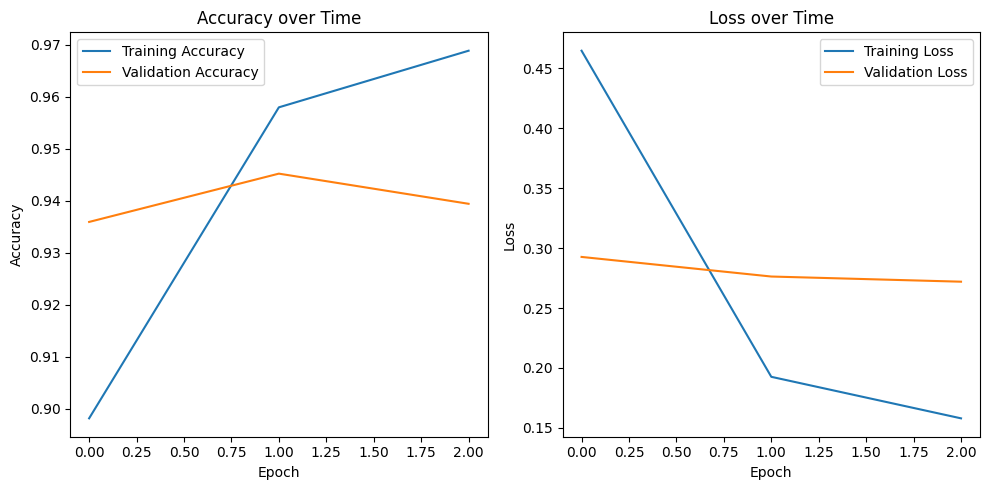

In [53]:
import matplotlib.pyplot as plt


# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Step 10: Save the trained model

In [55]:
# Save the trained model
model.save("/content/drive/MyDrive/Nepali POS Tagging/trained_model/lstm1/")

# Step 11: Load the trained model

In [56]:
from keras.models import load_model

# Load the trained model
loaded_model = load_model("/content/drive/MyDrive/Nepali POS Tagging/trained_model/lstm1/")

# Confusion matrix

770/770 [==============================] - 4s 4ms/step


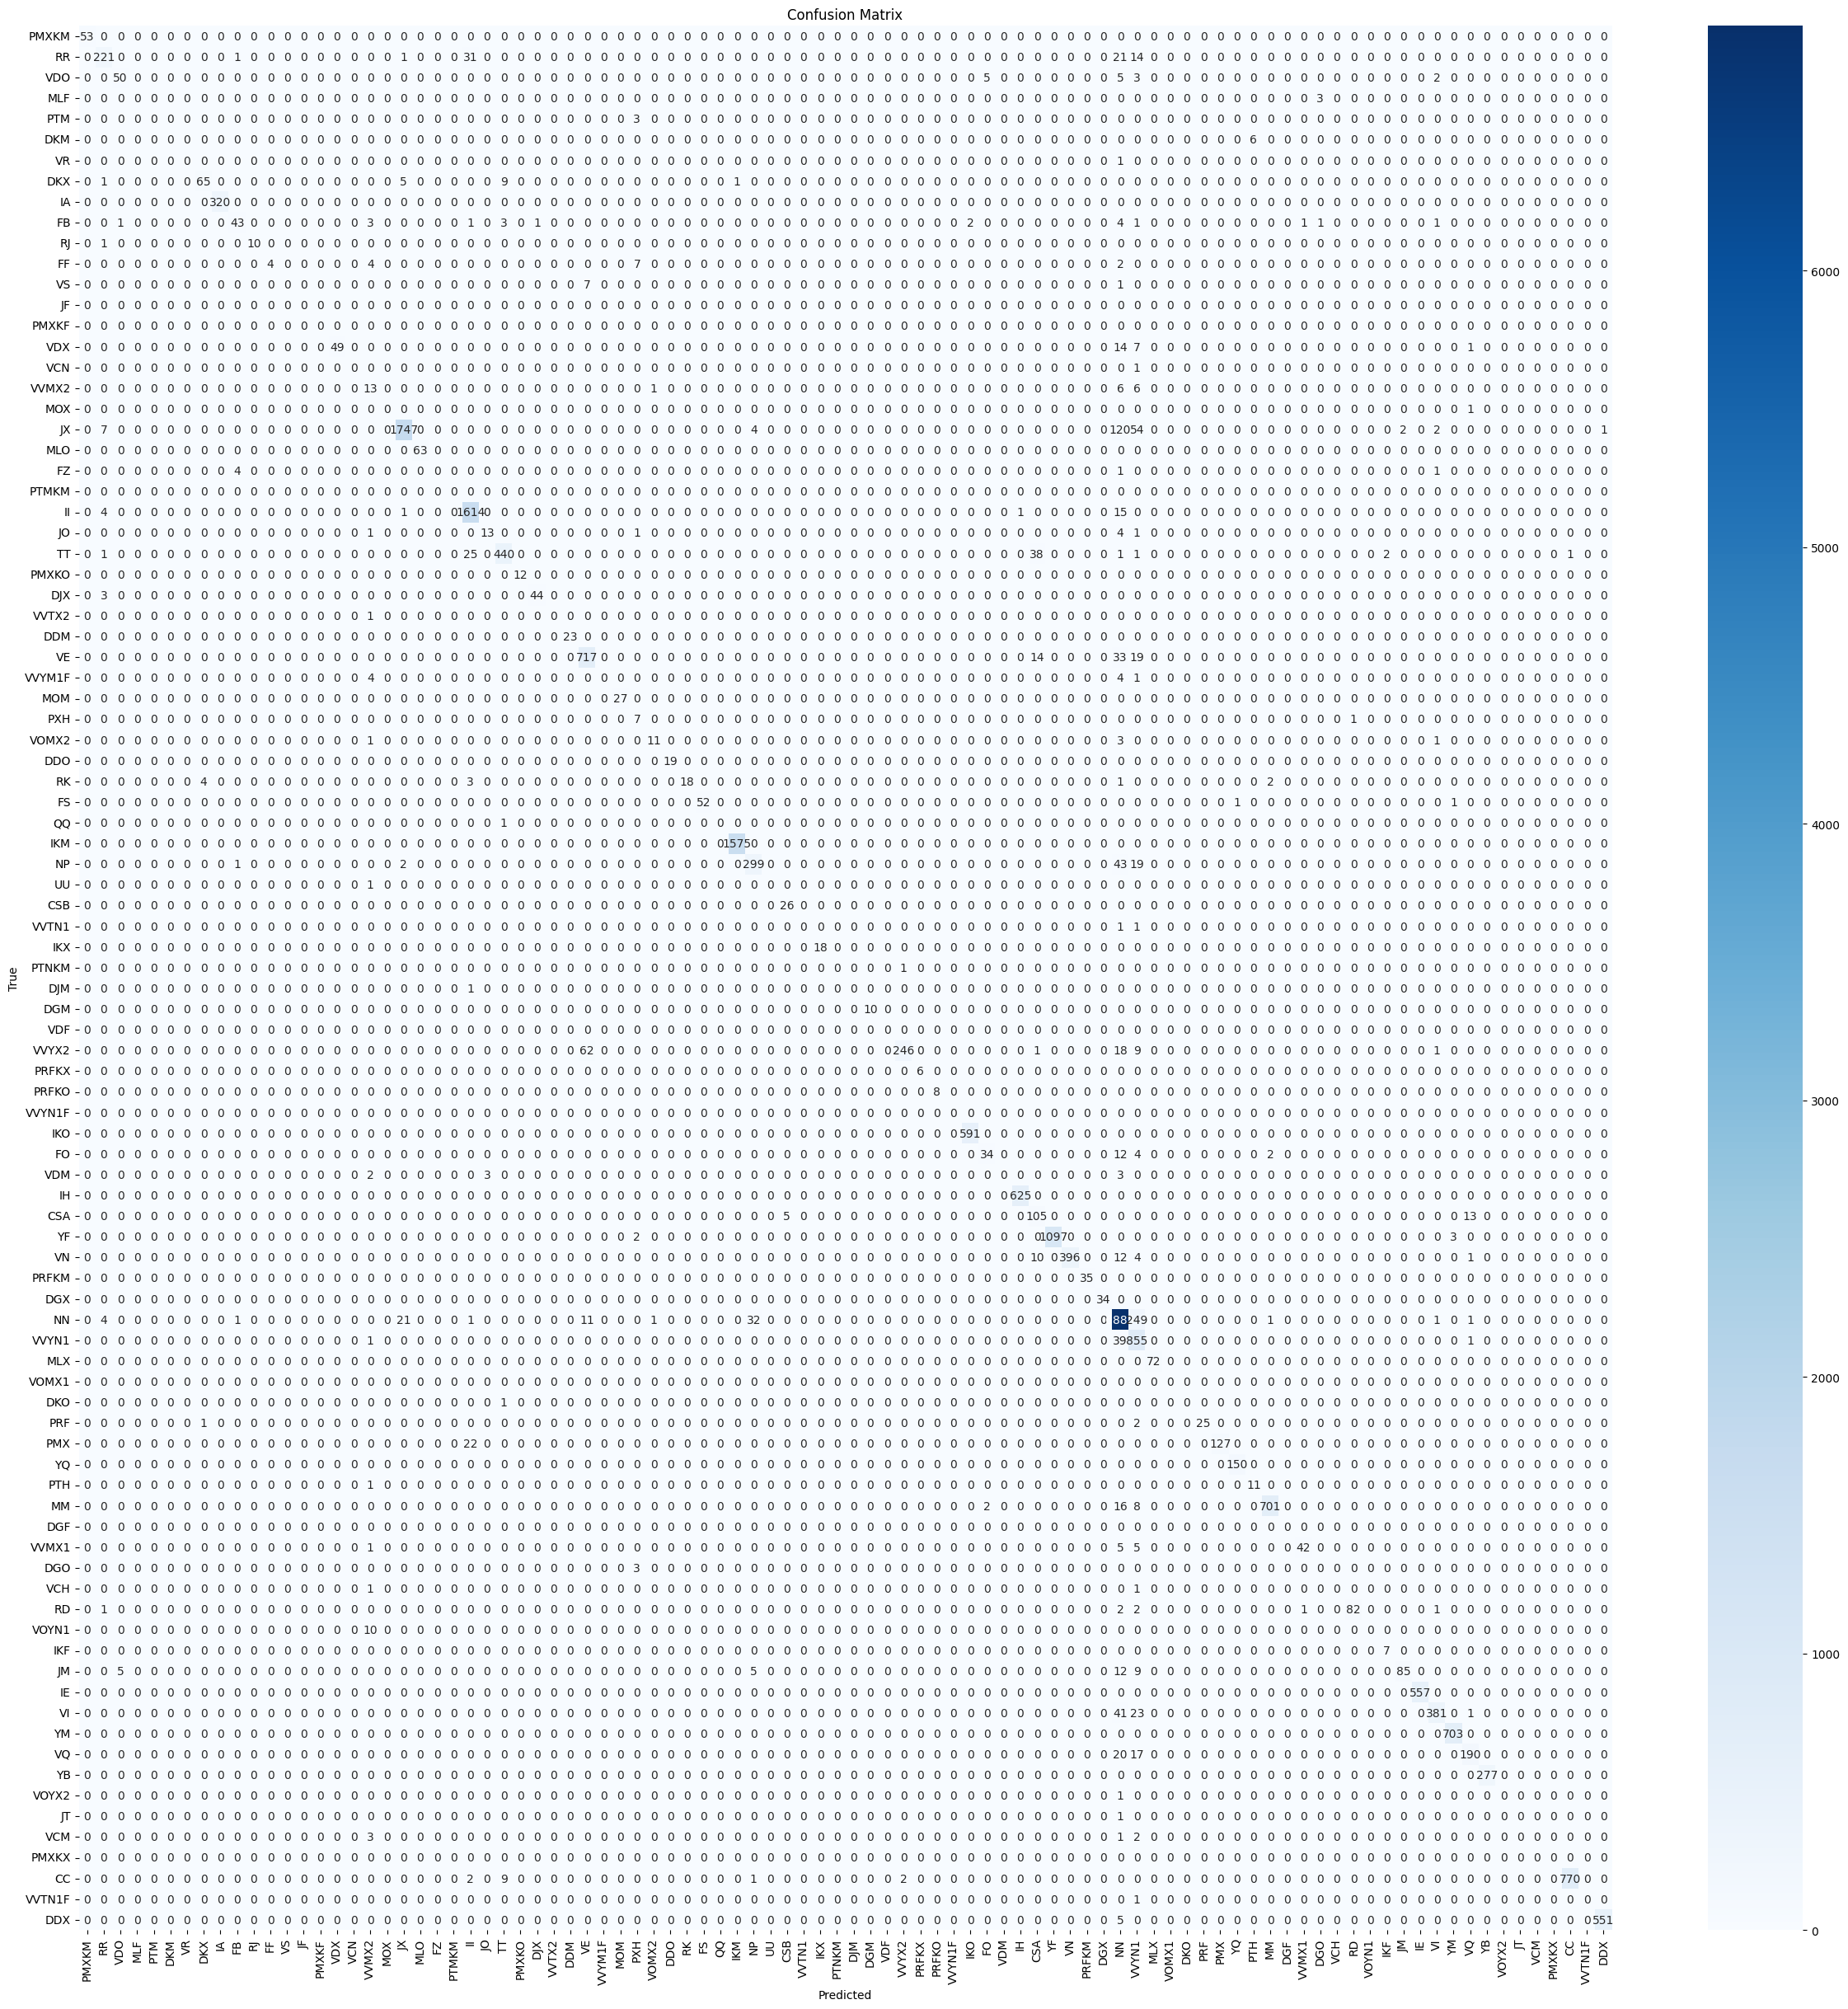

In [57]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test dataset
predictions = loaded_model.predict(X_test)

# Convert predicted indices to POS tags
predicted_tags = [list(tag_to_index.keys())[np.argmax(pred)] for pred in predictions]

# Convert true indices to POS tags
true_tags = [list(tag_to_index.keys())[idx] for idx in y_test.reshape(-1)]

# Create a confusion matrix
conf_matrix = confusion_matrix(true_tags, predicted_tags, labels=list(tag_set))

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(tag_set), yticklabels=list(tag_set))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Step 12: POS Tagging with the LSTM Model
You can now use the trained LSTM model for POS tagging new sentences:

In [58]:
new_sentence = "राम लेख लेख ।"
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_index[word] for word in tokenized_new_sentence]

predicted_tag_indices = loaded_model.predict(np.array([new_sentence_indices]))
predicted_tags = [list(tag_to_index.keys())[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

print(list(zip(tokenized_new_sentence, predicted_tags)))


1/1 [==============================] - 1s 559ms/step
[('राम', 'NP'), ('लेख', 'NN'), ('लेख', 'NN'), ('।', 'YF')]


# GRU


### 1. Train And Compile GRU model

#### Note:
If your target labels are integer class indices: Use `sparse_categorical_crossentropy`.

It expects the target labels to be of shape `(batch_size,)`, where each entry represents the class index of the corresponding sample.

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------

If your target labels are already one-hot encoded: Use `categorical_crossentropy`.

It expects the target labels to be of shape `(batch_size, num_classes)` where each row is a one-hot encoded vector corresponding to the class of the sample.

Otherwise it gives error.

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the learning rate
# learning_rate = 0.001  # You can adjust this value as needed

# Build the GRU model
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_sequence_length))
model2.add(GRU(128, return_sequences=True))  # Using GRU layer instead of LSTM
model2.add(Dropout(0.3))  # Adding a dropout layer with 20% dropout rate
model2.add(Dense(64, activation='relu'))  # Adding an additional dense layer
model2.add(Dense(len(tag_set), activation='softmax'))

# Compile the model with the specified learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
# Compile the model
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 100)            1461300   
                                                                 
 gru_1 (GRU)                 (None, 1, 128)            88320     
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_2 (Dense)             (None, 1, 64)             8256      
                                                                 
 dense_3 (Dense)             (None, 1, 92)             5980      
                                                                 
Total params: 1,563,856
Trainable params: 1,563,856
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Train the model
history2 = model2.fit(train_dataset, epochs=3, batch_size=128, validation_data=val_dataset, verbose='auto')

Epoch 1/3
114984/114984 [==============================] - 3406s 30ms/step - loss: 0.4513 - accuracy: 0.9007 - val_loss: 0.2985 - val_accuracy: 0.9349
Epoch 2/3
114984/114984 [==============================] - 3132s 27ms/step - loss: 0.1860 - accuracy: 0.9600 - val_loss: 0.2717 - val_accuracy: 0.9429
Epoch 3/3
114984/114984 [==============================] - 3642s 32ms/step - loss: 0.1499 - accuracy: 0.9710 - val_loss: 0.2678 - val_accuracy: 0.9504


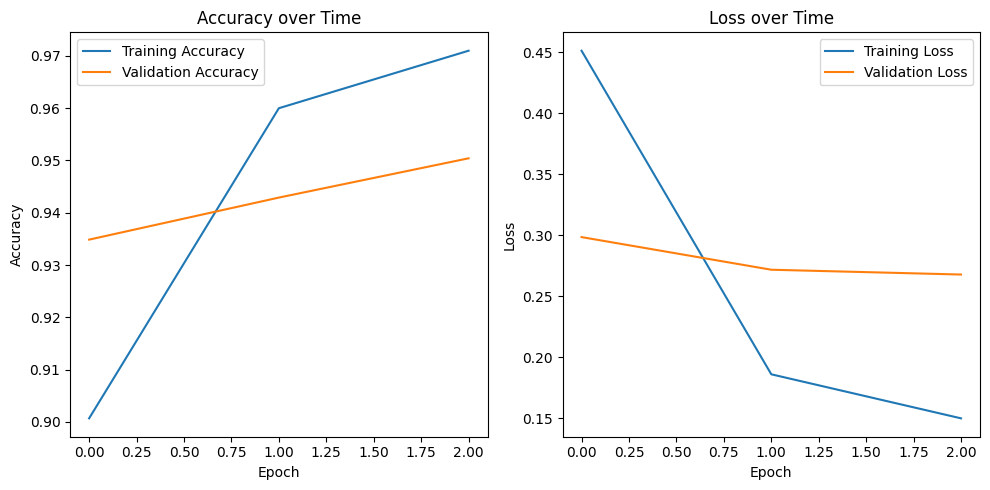

In [23]:
import matplotlib.pyplot as plt


# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
model2.save("/content/drive/MyDrive/Nepali POS Tagging/trained_model/gru/")

In [45]:
from keras.models import load_model

# Load the trained model
loaded_model2 = load_model("/content/drive/MyDrive/Nepali POS Tagging/trained_model/gru/")

In [26]:
# Evaluate the model
loss, accuracy = loaded_model2.evaluate(test_dataset)

24640/24640 [==============================] - 68s 3ms/step - loss: 0.2594 - accuracy: 0.9516


770/770 [==============================] - 5s 3ms/step


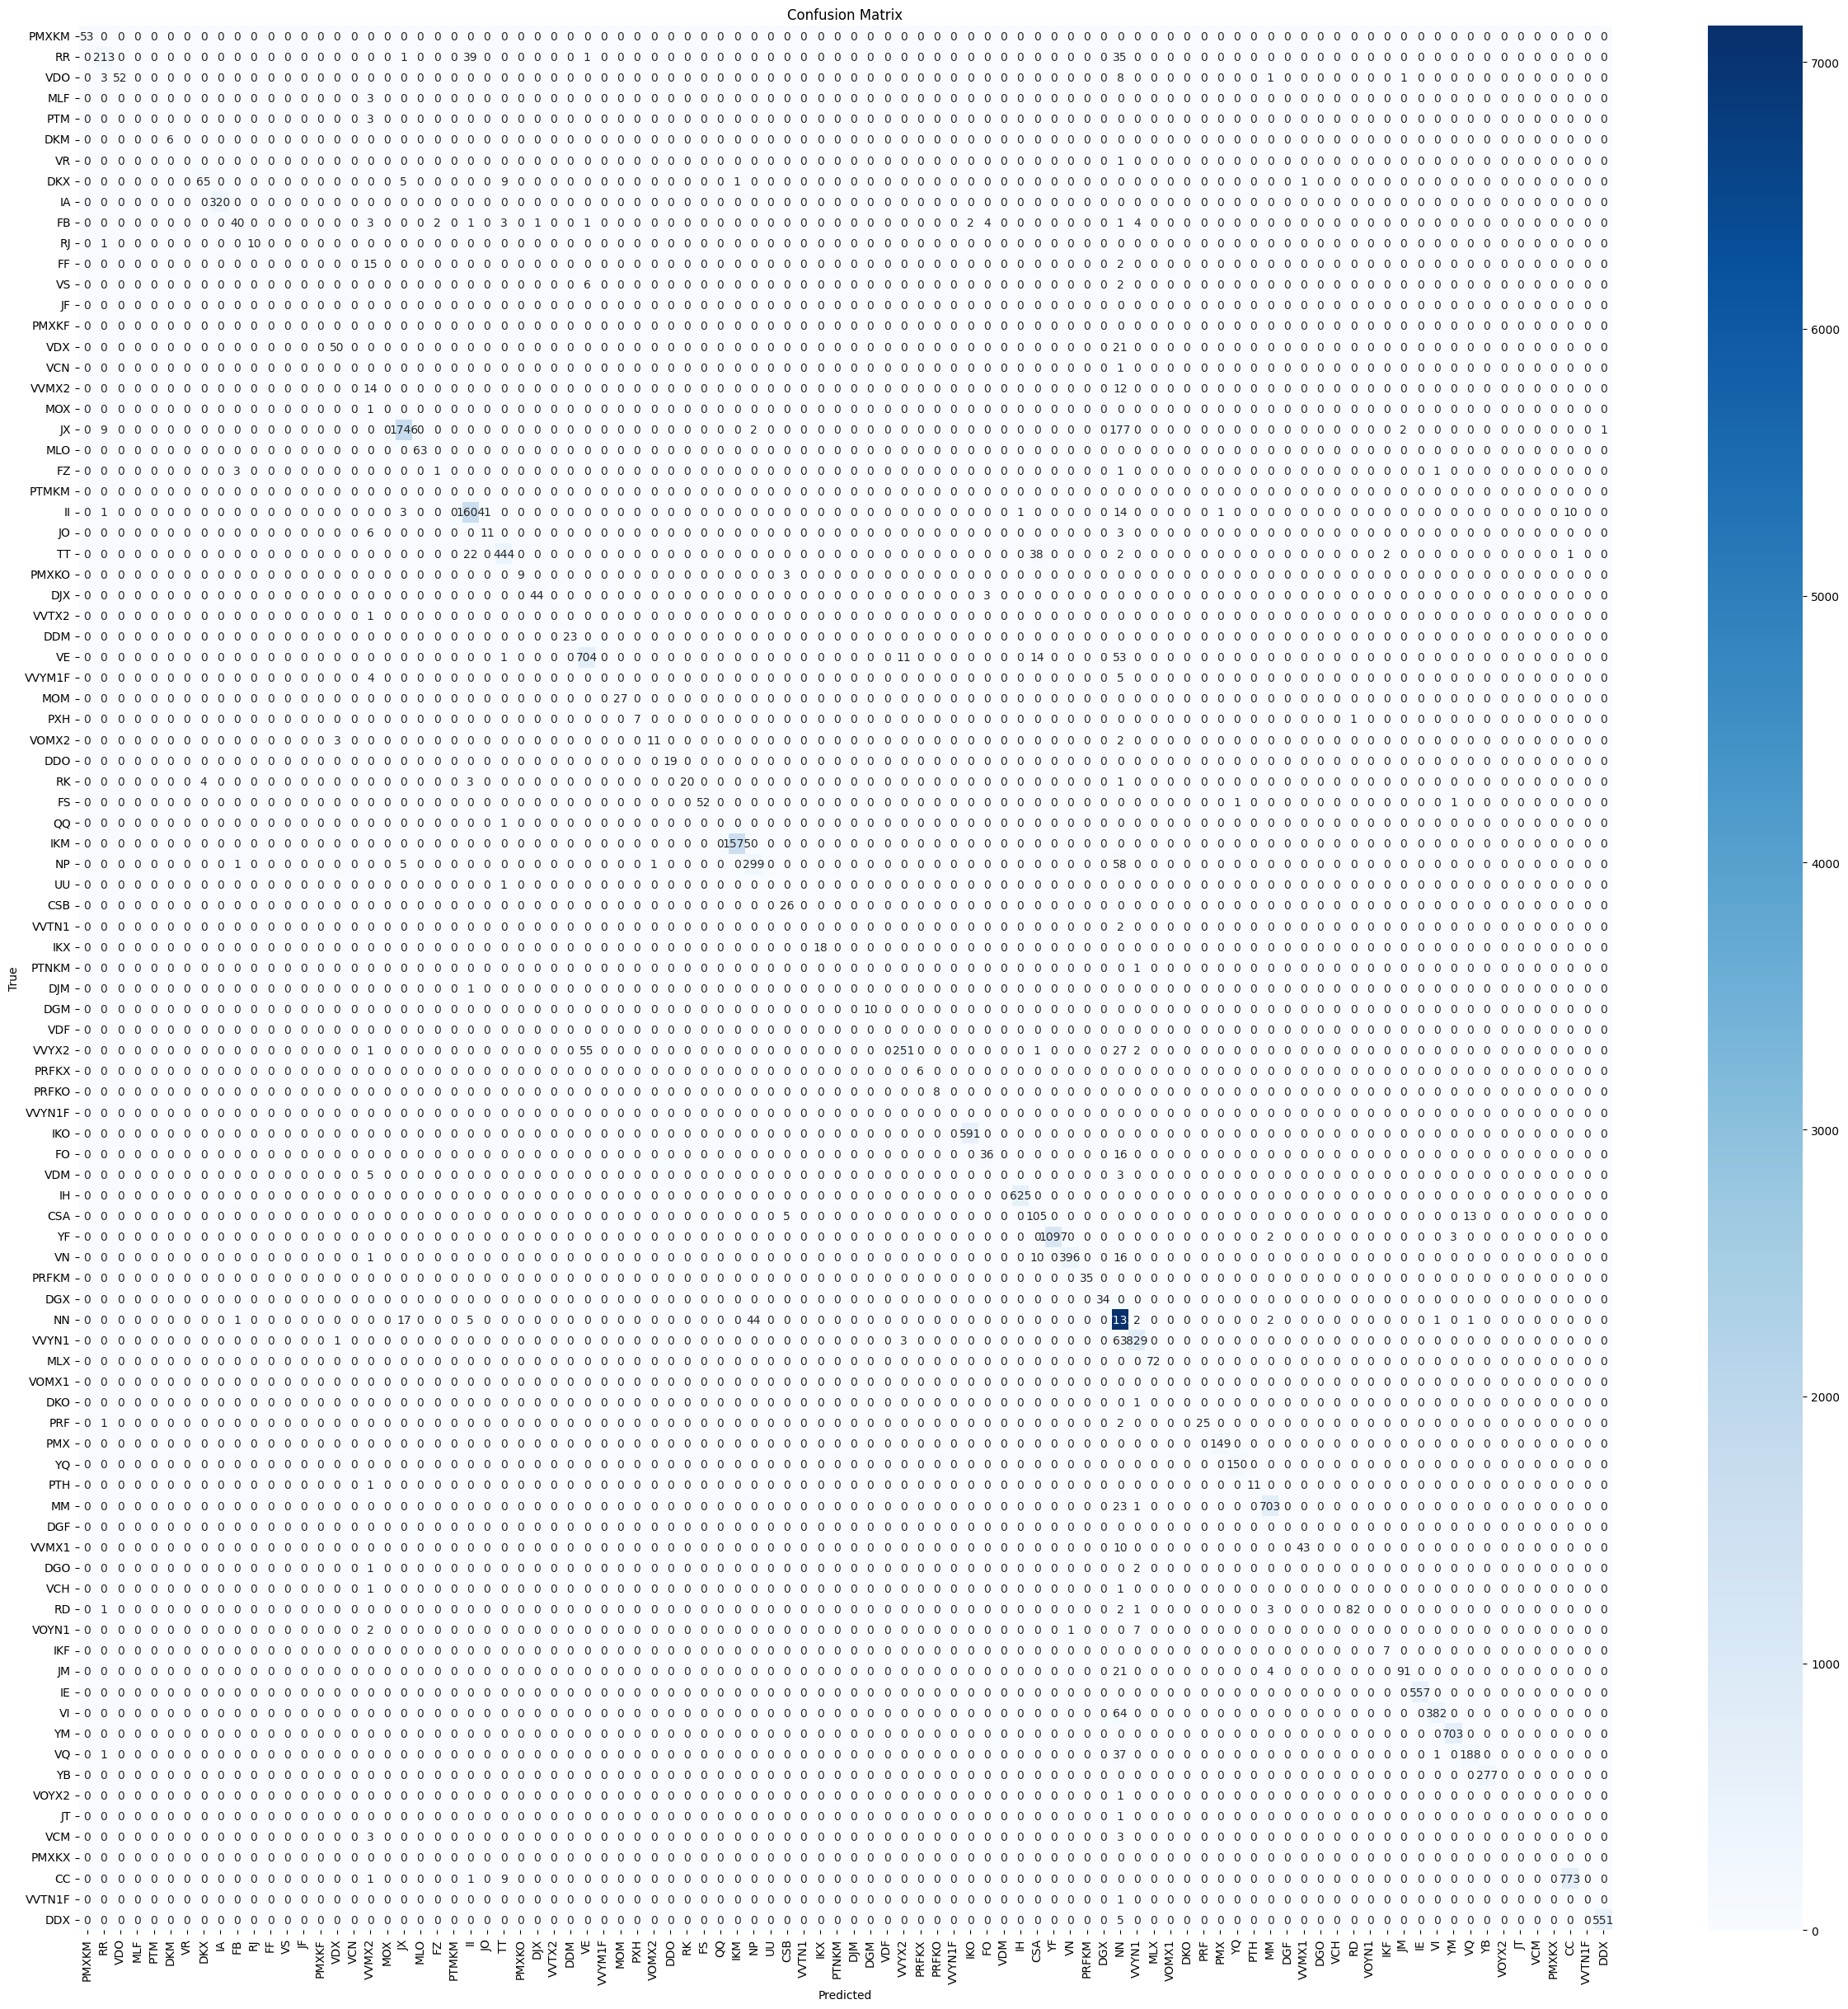

In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test dataset
predictions = loaded_model2.predict(X_test)

# Convert predicted indices to POS tags
predicted_tags = [list(tag_to_index.keys())[np.argmax(pred)] for pred in predictions]

# Convert true indices to POS tags
true_tags = [list(tag_to_index.keys())[idx] for idx in y_test.reshape(-1)]

# Create a confusion matrix
conf_matrix = confusion_matrix(true_tags, predicted_tags, labels=list(tag_set))

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(tag_set), yticklabels=list(tag_set))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
new_sentence = "राम लेख लेख ।"
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_index[word] for word in tokenized_new_sentence]

predicted_tag_indices = loaded_model2.predict(np.array([new_sentence_indices]))
predicted_tags = [list(tag_to_index.keys())[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

print(list(zip(tokenized_new_sentence, predicted_tags)))

1/1 [==============================] - 1s 668ms/step
[('राम', 'NP'), ('लेख', 'NN'), ('लेख', 'NN'), ('।', 'YF')]


In [30]:
new_sentence = "सुन्दा अचम्म लाग्न सक्छ, तर युरोपेली युनियन भित्रै का देश मा बस्ने मानिस अझै पनि इन्टरनेट किन्न असमर्थ छन् ।"
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_index[word] for word in tokenized_new_sentence]

predicted_tag_indices = loaded_model2.predict(np.array([new_sentence_indices]))
predicted_tags = [list(tag_to_index.keys())[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

print(list(zip(tokenized_new_sentence, predicted_tags)))

1/1 [==============================] - 1s 666ms/step
[('सुन्दा', 'VDO'), ('अचम्म', 'VDO'), ('लाग्न', 'VDO'), ('सक्छ', 'VVYN1'), (',', 'YM'), ('तर', 'IH'), ('युरोपेली', 'IH'), ('युनियन', 'IH'), ('भित्रै', 'II'), ('का', 'IKO'), ('देश', 'IKO'), ('मा', 'II'), ('बस्ने', 'II'), ('मानिस', 'II'), ('अझै', 'IKO'), ('पनि', 'II'), ('इन्टरनेट', 'II'), ('किन्न', 'II'), ('असमर्थ', 'II'), ('छन्', 'II'), ('।', 'IKO')]


# BiLSTM

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Build the BiLSTM model
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_sequence_length))
model3.add(Bidirectional(LSTM(128, return_sequences=True)))  # Using Bidirectional LSTM layer
model3.add(Dropout(0.3))  # Adding a dropout layer with 20% dropout rate
model3.add(Dense(64, activation='relu'))  # Adding an additional dense layer
model3.add(Dense(len(tag_set), activation='softmax'))


model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1, 100)            1461300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           234496    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 1, 256)            0         
                                                                 
 dense_6 (Dense)             (None, 1, 64)             16448     
                                                                 
 dense_7 (Dense)             (None, 1, 92)             5980      
                                                                 
Total params: 1,718,224
Trainable params: 1,718,224
Non-trainable params: 0
____________________________________________

In [33]:
# Train the model
history3 = model3.fit(train_dataset, epochs=3, batch_size=128, validation_data=val_dataset, verbose='auto')

Epoch 1/3
114984/114984 [==============================] - 3998s 35ms/step - loss: 0.4526 - accuracy: 0.9001 - val_loss: 0.2937 - val_accuracy: 0.9352
Epoch 2/3
114984/114984 [==============================] - 4070s 35ms/step - loss: 0.1906 - accuracy: 0.9582 - val_loss: 0.3054 - val_accuracy: 0.9401
Epoch 3/3
114984/114984 [==============================] - 4026s 35ms/step - loss: 0.1571 - accuracy: 0.9691 - val_loss: 0.2952 - val_accuracy: 0.9498


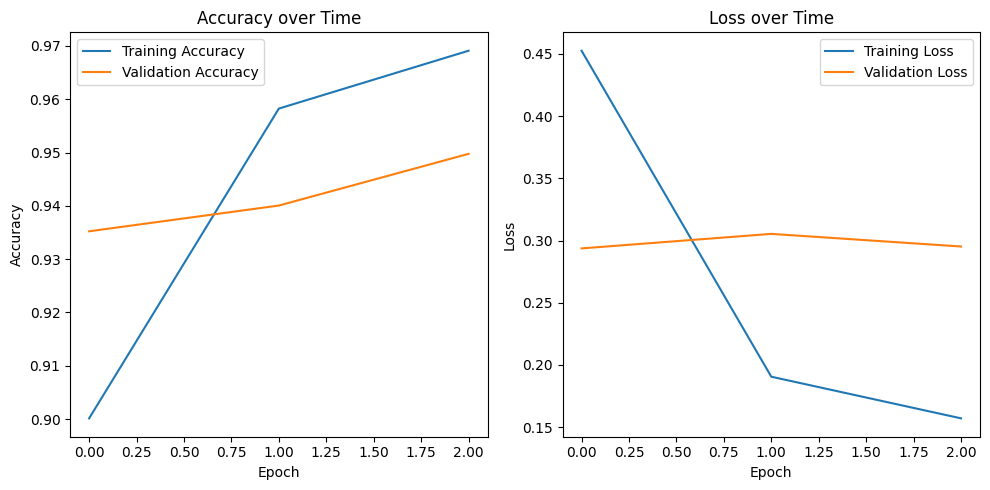

In [34]:
import matplotlib.pyplot as plt


# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
model3.save("/content/drive/MyDrive/Nepali POS Tagging/trained_model/bilstm/")

In [36]:
from keras.models import load_model

# Load the trained model
loaded_model3 = load_model("/content/drive/MyDrive/Nepali POS Tagging/trained_model/bilstm/")

In [37]:
# Evaluate the model
loss, accuracy = loaded_model3.evaluate(test_dataset)

24640/24640 [==============================] - 101s 4ms/step - loss: 0.2858 - accuracy: 0.9519


# Confusion matrix

770/770 [==============================] - 6s 7ms/step


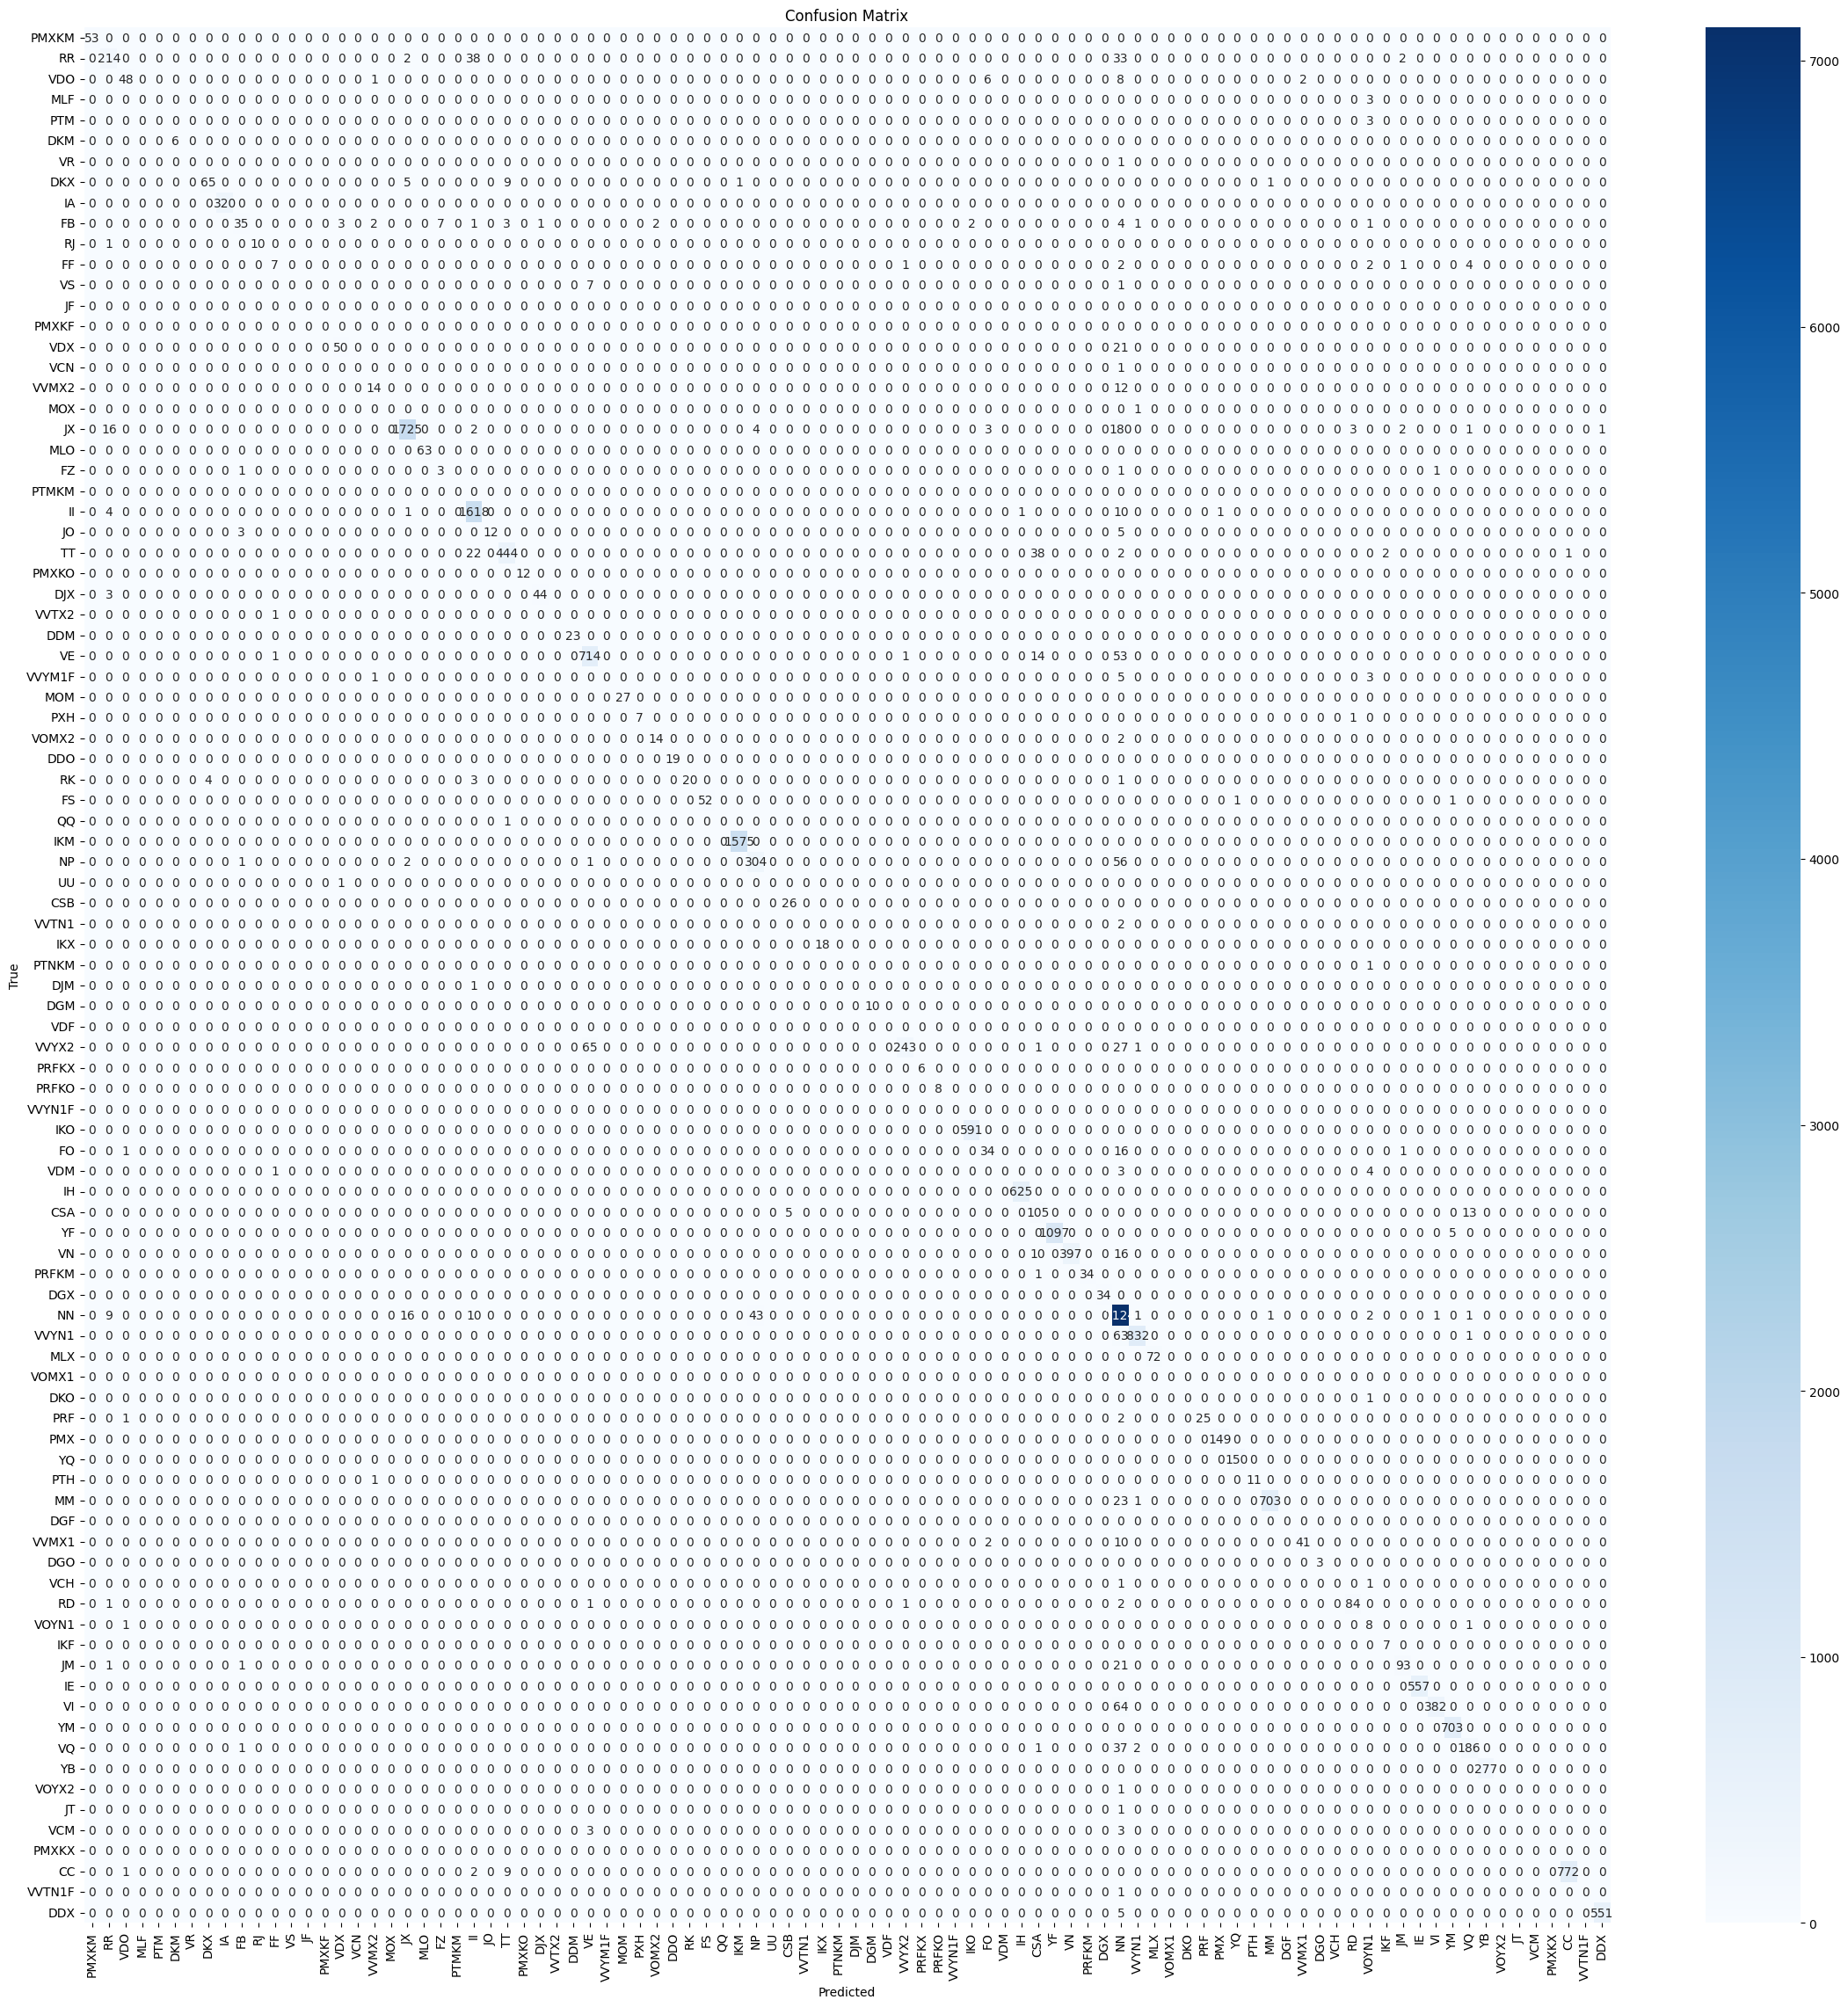

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test dataset
predictions = model3.predict(X_test)

# Convert predicted indices to POS tags
predicted_tags = [list(tag_to_index.keys())[np.argmax(pred)] for pred in predictions]

# Convert true indices to POS tags
true_tags = [list(tag_to_index.keys())[idx] for idx in y_test.reshape(-1)]

# Create a confusion matrix
conf_matrix = confusion_matrix(true_tags, predicted_tags, labels=list(tag_set))

# Plot the confusion matrix
plt.figure(figsize=(28, 28))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(tag_set), yticklabels=list(tag_set))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
new_sentence = "राम लेख लेख ।"
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_index[word] for word in tokenized_new_sentence]

predicted_tag_indices = loaded_model3.predict(np.array([new_sentence_indices]))
predicted_tags = [list(tag_to_index.keys())[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

print(list(zip(tokenized_new_sentence, predicted_tags)))

1/1 [==============================] - 1s 1s/step
[('राम', 'NP'), ('लेख', 'NN'), ('लेख', 'NN'), ('।', 'YF')]
